<a href="https://colab.research.google.com/github/indrajeetapache/kaggle-solutions/blob/main/Kaggle_LLM_SCIENCE_EXAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install kaggle

In [ ]:
from google.colab import drive
drive.mount("/content/driver")

Mounted at /content/driver


# Make a dir

In [ ]:
# !mkdir ~/.kaggle
# !mkdir -p ~/kaggle/input/kaggle-llm-science-exam
# #!mkdir ~/.kaggle/input/kaggle-llm-science-exam

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
# !mkdir -p /kaggle/input/kaggle-llm-science-exam

In [ ]:
# !cp /content/driver/MyDrive/kaggle_account/kaggle.json ~/.kaggle
# ! chmod 600 /root/.kaggle/kaggle.json

*Download the compition data*

In [ ]:
# ! kaggle competitions download -c kaggle-llm-science-exam

100% 72.5k/72.5k [00:00<00:00, 624kB/s]
100% 72.5k/72.5k [00:00<00:00, 623kB/s]


In [ ]:
# !unzip kaggle-llm-science-exam.zip -d /kaggle/input/kaggle-llm-science-exam

Archive:  kaggle-llm-science-exam.zip
  inflating: /kaggle/input/kaggle-llm-science-exam/sample_submission.csv  
  inflating: /kaggle/input/kaggle-llm-science-exam/test.csv  
  inflating: /kaggle/input/kaggle-llm-science-exam/train.csv  


*importing the required lib*

In [ ]:
# ! pip install -q tensorflow_text
# ! pip install -q transformers
# ! pip install -q schedule


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.8/489.8 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 63.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 110.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 44.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 96.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 64.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 60.7 MB/s eta 0:00:00


In [ ]:
! pip install  scheduler

  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.5.0
    Uninstalling typing_extensions-4.5.0:
      Successfully uninstalled typing_extensions-4.5.0


In [ ]:
import keras
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
import random
from sklearn.model_selection import KFold
from tensorflow.keras.layers import concatenate
from transformers import BertTokenizer
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch
import numpy as np
import schedule

*TRAIN DATAFRAME CREATION*

In [ ]:
train_df = pd.read_csv('/kaggle/input/kaggle-llm-science-exam/train.csv')
test_df = pd.read_csv('/kaggle/input/kaggle-llm-science-exam/test.csv')

*DATA DISTRIBUTION*

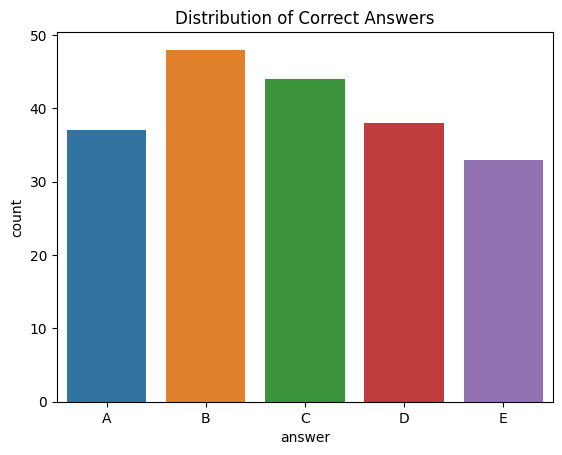

'\n1. Seems the data has been evenly distributed there is no imbalance is there\n'

In [ ]:
sns.countplot(data=train_df, x='answer', order=['A', 'B', 'C', 'D', 'E'])
plt.title("Distribution of Correct Answers")
plt.show()

"""
1. Seems the data has been evenly distributed there is no imbalance is there
"""

*Length Distribution of the Prompt*

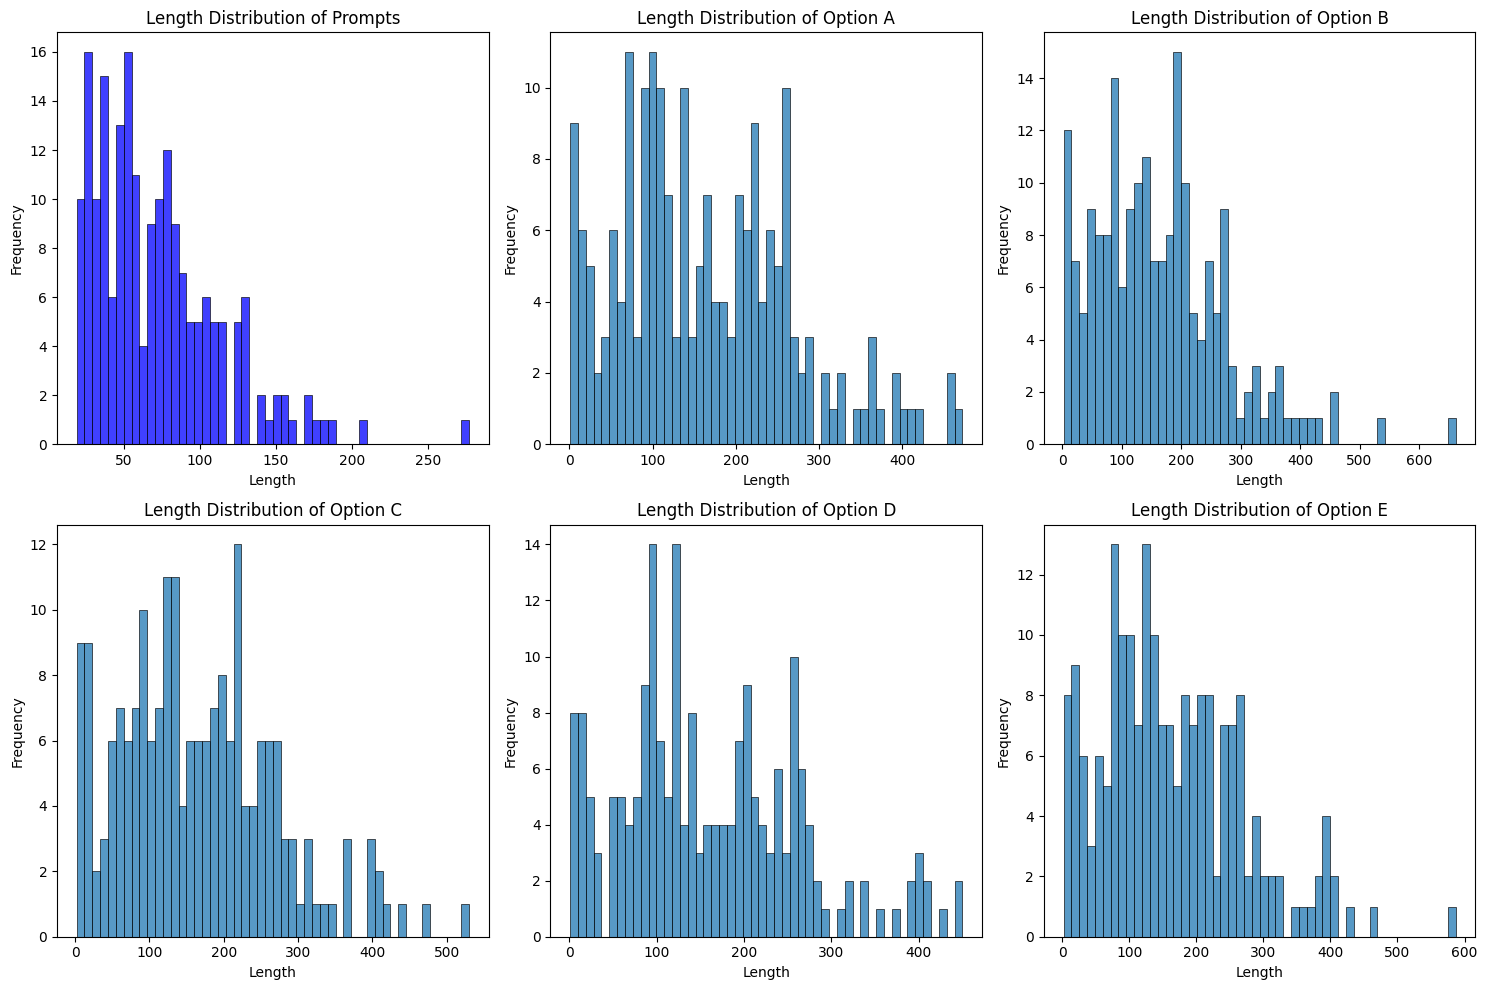

In [ ]:
train_df['prompt_length'] = train_df['prompt'].str.len()
for option in ['A', 'B', 'C', 'D', 'E']:
    train_df[f'{option}_length'] = train_df[option].str.len()

plt.figure(figsize=(15, 10))
plt.subplot(2, 3, 1)
sns.histplot(train_df['prompt_length'], bins=50, color='blue')
plt.title('Length Distribution of Prompts')
plt.xlabel('Length')
plt.ylabel('Frequency')
for i, option in enumerate(['A', 'B', 'C', 'D', 'E'], start=2):
    plt.subplot(2, 3, i)
    sns.histplot(train_df[f'{option}_length'], bins=50)
    plt.title(f'Length Distribution of Option {option}')
    plt.xlabel('Length')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

*Lets Identify the most frequently used words in the questions.*

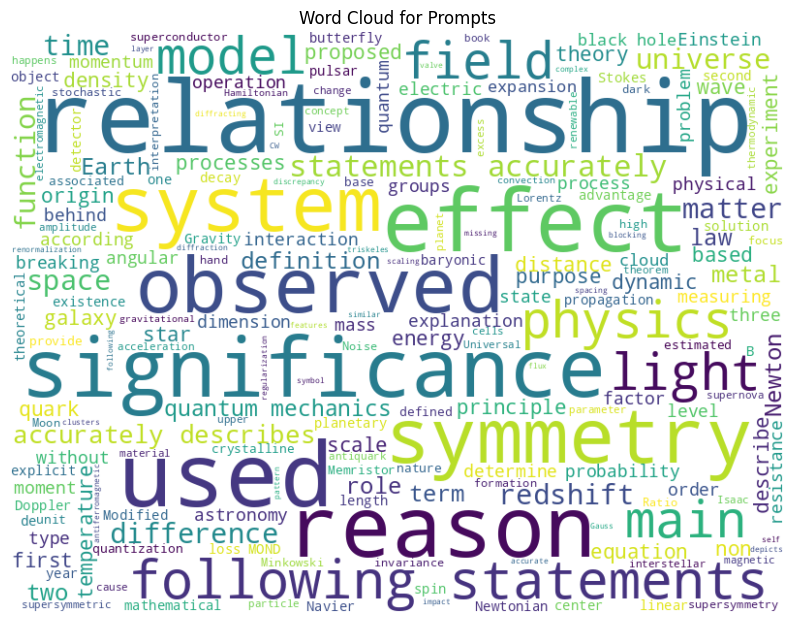

In [ ]:
text = ' '.join(train_df['prompt'])
wordcloud = WordCloud(background_color='white', width=800, height=600).generate(text)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Prompts')
plt.show()

*Data Preprocessing*

In [ ]:
# Define the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the data
prompts = train_df['prompt'].values
options = ['A', 'B', 'C', 'D', 'E']
encoded_data = []

for index, row in train_df.iterrows():
    for option in options:
        encoded = tokenizer.encode_plus(
        row['prompt'],
        row[option],
        add_special_tokens=True,
        max_length=256,
        padding='max_length',  # Replace pad_to_max_length=True
        truncation=True,  # Explicitly activate truncation
        return_attention_mask=True,
        return_tensors='pt'
    )

        encoded_data.append((encoded['input_ids'], encoded['attention_mask'], 1 if row['answer'] == option else 0))

In [ ]:
input_ids = torch.cat([item[0] for item in encoded_data], dim=0)
attention_masks = torch.cat([item[1] for item in encoded_data], dim=0)
labels = torch.tensor([item[2] for item in encoded_data])

In [ ]:
dataset = TensorDataset(input_ids, attention_masks, labels)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)

*Model Development*

In [ ]:
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False
)

# Define optimizer and loss
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
loss_fn = torch.nn.CrossEntropyLoss()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


*Training*

In [ ]:
epochs = 3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in train_dataloader:
        batch = tuple(b.to(device) for b in batch)
        inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}
        model.zero_grad()

        outputs = model(**inputs)
        loss = loss_fn(outputs.logits, inputs['labels'])
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Epoch: {epoch + 1}, Train Loss: {avg_train_loss:.3f}")

Epoch: 1, Train Loss: 0.533
Epoch: 2, Train Loss: 0.523
Epoch: 3, Train Loss: 0.524


*Evaluation*

In [ ]:
model.eval()

predictions, true_labels = [], []

for batch in val_dataloader:
    batch = tuple(b.to(device) for b in batch)
    with torch.no_grad():
        outputs = model(input_ids=batch[0], attention_mask=batch[1])
    logits = outputs.logits
    logits = logits.detach().cpu().numpy()
    label_ids = batch[2].cpu().numpy()
    predictions.append(logits)
    true_labels.append(label_ids)

In [ ]:


# 1. Process the logits to get the predicted classes
predicted_classes = [np.argmax(logit, axis=1) for logit in predictions]
predicted_classes_flat = [item for sublist in predicted_classes for item in sublist]

true_labels_flat = [item for sublist in true_labels for item in sublist]

# 2. Compare the predicted classes with the true labels
correct_predictions = np.sum(np.array(predicted_classes_flat) == np.array(true_labels_flat))

# 3. Print the results
print(f"Total Predictions: {len(true_labels_flat)}")
print(f"Correct Predictions: {correct_predictions}")
print(f"Accuracy: {correct_predictions / len(true_labels_flat) * 100:.2f}%")

Total Predictions: 100
Correct Predictions: 89
Accuracy: 89.00%


*Validation using test set*

In [ ]:
def prepare_row_for_prediction(row, tokenizer):
    options = ['A', 'B', 'C', 'D', 'E']
    encoded_data = []

    for option in options:
        encoded = tokenizer.encode_plus(
            row['prompt'],
            row[option],
            add_special_tokens=True,
            max_length=256,
            padding='max_length',  # Replace pad_to_max_length=True
            truncation=True,  # Explicitly activate truncation
            return_attention_mask=True,
            return_tensors='pt'
        )

        # Store the encoded data
        encoded_data.append((encoded['input_ids'], encoded['attention_mask']))

    return encoded_data

def process_logits_to_class(logits):
    # Use np.argmax to find the index of the maximum value in logits
    predicted_index = np.argmax(logits, axis=1)

    # Map the index to the corresponding class label ('A', 'B', 'C', 'D', 'E')
    class_labels = ['A', 'B', 'C', 'D', 'E']
    predicted_class = [class_labels[i] for i in predicted_index]

    return predicted_class


In [ ]:
# Assuming 'model' is your trained model and 'test_df' is your test DataFrame
model.eval()

# Initialize an empty list to store the predictions
predictions = []

# Loop through the test DataFrame to prepare each row for prediction
for index, row in test_df.iterrows():
    # Here, add code to prepare each row of the DataFrame for prediction
    prepared_data = prepare_row_for_prediction(row, tokenizer)  # You will need to define this function

    # Use the model to generate logits for the prepared data
    with torch.no_grad():
        outputs = model(input_ids=batch[0], attention_mask=batch[1])  # Replace **prepared_data with the correct input format for your model
    logits = outputs.logits
    logits = logits.detach().cpu().numpy()

    # Add code here to process the logits and extract the final predicted class
    predicted_class = process_logits_to_class(logits)  # You will need to define this function
    predictions.append(predicted_class)





In [ ]:
# Create a DataFrame for the submission
submission_df = pd.DataFrame({
    'id': test_df['id'],  # Replace 'Id' with the correct identifier column name if different
    'Answer': predictions  # Replace 'Answer' with the correct target column name if different
})


In [ ]:
import subprocess
from subprocess import PIPE, run
from io import StringIO
competition_name = "kaggle-llm-science-exam"
proc = subprocess.run(f"kaggle competitions submissions -v {competition_name}",
                      shell=True, stdout=PIPE, stderr=PIPE, text=True)
ret = proc.stdout
df = pd.read_csv(StringIO(ret))
df.head()

,No submissions found


In [ ]:
test_df.columns

Index(['id', 'prompt', 'A', 'B', 'C', 'D', 'E'], dtype='object')